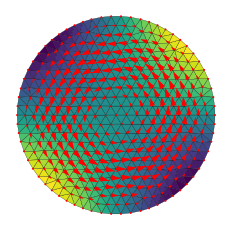

In [20]:
from skfem import *
from skfem.models.poisson import vector_laplace, mass, laplace
from skfem.models.general import divergence, rot

import numpy as np
from scipy.sparse import bmat

import dmsh

mesh = MeshTri(*map(np.transpose,
                    dmsh.generate(dmsh.Circle([0., 0.], 1.), .1)))

element = {'u': ElementVectorH1(ElementTriP2()),
           'p': ElementTriP1()}
basis = {variable: InteriorBasis(mesh, e, intorder=3)
         for variable, e in element.items()}


@linear_form
def body_force(v, dv, w):
    return w.x[0] * v[1]


A = asm(vector_laplace, basis['u'])
B = asm(divergence, basis['u'], basis['p'])
C = asm(mass, basis['p'])

K = bmat([[A, -B.T],
          [-B, 1e-6 * C]]).tocsr()

f = np.concatenate([asm(body_force, basis['u']),
                    np.zeros(B.shape[0])])

D = basis['u'].get_dofs().all()
#uvp = np.zeros(K.shape[0])

#uvp[np.setdiff1d(np.arange(K.shape[0]), D)] = 
uvp = solve(*condense(K, f, D=D))

velocity, pressure = np.split(uvp, [A.shape[0]])

from matplotlib.tri import Triangulation

ax = mesh.plot(pressure)

velocity1 = velocity[basis['u'].nodal_dofs]
ax.quiver(*mesh.p, *velocity1, width=.01, color='r')  # colour by buoyancy

In [18]:
ax.quiver?

In [ ]:
m = skfem.MeshTri()
m.refine(4)

e = skfem.ElementTriP1()
basis = skfem.InteriorBasis(m, e)

@skfem.bilinear_form
def laplace(u, du, v, dv, w):
    return du[0]*dv[0] + du[1]*dv[1]

@skfem.linear_form
def load(v, dv, w):
    return 1.0*v

A = skfem.asm(laplace, basis)
b = skfem.asm(load, basis)
Aorig = A.copy()
#A, b, x, I = skfem.condense(A, b, I=m.interior_nodes())

print(A.shape)
print(b.shape)

res = []
def mgsolver(A, b):
    mg = pyamg.smoothed_aggregation_solver(A, b)
    return mg.solve(b, residuals=res)

#x = skfem.solve(A, b, x, I, solver=mgsolver)
x = skfem.solve(A, b, solver=mgsolver)


m.plot(x, smooth=True, colorbar=True)